In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

from astropy.io import fits
from astropy.table import Table, hstack
from astropy.wcs import WCS
from astropy import coordinates as coord
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord

# DATA PREP

In [2]:
catalog = Table.read('SDSS_DR7_catlaog_vollim.dat', format='ascii')
print(catalog.colnames)
print(len(catalog))

Austin_class = Table.read("galaxy_void_classifications.dat", format='ascii')
print(Austin_class.colnames)
print(len(Austin_class))

Austin_data = Table.read("vollim_dr7_cbp_102709.dat" , format='ascii')
print(Austin_data.colnames)
print(len(Austin_data))

['ra', 'dec', 'redshift', 'Rgal', 'rabsmag']
120606
['Index', 'X', 'Y', 'Z', 'Void Classification']
107490
['ra', 'dec', 'redshift', 'Rgal', 'rabsmag']
120606


# CONVERT TO XYZ

In [3]:
# Convert redshift to comoving distance in Mpc/h

"""
find xyz coordinates from redshift using astropy cosmology
"""

comoving_dist = Planck18.comoving_distance(catalog['redshift']).to(u.Mpc).value
comoving_dist_mpc_h = comoving_dist * Planck18.h  # Convert to Mpc/h

# Create SkyCoord object with distances
coords = SkyCoord(
ra=catalog['ra'] * u.deg,
dec=catalog['dec'] * u.deg,
distance=catalog["Rgal"] * u.Mpc,
frame='icrs')

# Extract Cartesian coordinates
catalog['x'] = coords.cartesian.x.value
catalog['y'] = coords.cartesian.y.value
catalog['z'] = coords.cartesian.z.value

# Done! Table now has x, y, z
catalog.pprint()

print(np.min(catalog['x']))
print(np.min(catalog['y']))
print(np.min(catalog['z']))







    ra        dec    redshift ...          y                   z          
---------- --------- -------- ... ------------------- --------------------
171.592148 -1.054439 0.077352 ...  33.380439456979786   -4.201818507222872
174.536224 -1.051174  0.07771 ...  21.836113888392614   -4.207888553508546
239.382782 -0.467646 0.084655 ... -214.71841309343415  -2.0364686358911204
239.679092 -0.448756 0.051608 ... -132.18813677073487  -1.1994215246262816
239.698471 -0.450346 0.051549 ... -132.06747809734955   -1.202334951667533
240.629196 -0.597995 0.094277 ...  -241.6524768705178  -2.8942268386243404
240.581787 -0.432649 0.060939 ... -157.20401535690624   -1.362818520396651
 240.66481 -0.506757 0.057744 ...  -149.1799148683226  -1.5135529265773187
241.260864  -0.42664 0.058116 ... -151.00139949646262   -1.282385237152892
241.320633 -0.488067 0.094263 ... -243.24542521225908   -2.361861582787674
       ...       ...      ... ...                 ...                  ...
254.179977 27.821945 0.03

In [4]:
print(len(catalog))
catalog 

120606


ra,dec,redshift,Rgal,rabsmag,x,y,z
float64,float64,float64,float64,float64,float64,float64,float64
171.592148,-1.054439,0.077352,228.33,-20.697,-225.83772909523174,33.380439456979786,-4.201818507222872
174.536224,-1.051174,0.07771,229.37,-20.283,-228.2894537734374,21.836113888392614,-4.207888553508546
239.382782,-0.467646,0.084655,249.51,-20.718,-127.07122402075295,-214.71841309343415,-2.0364686358911204
239.679092,-0.448756,0.051608,153.14,-20.687,-77.30923285796948,-132.18813677073487,-1.1994215246262816
239.698471,-0.450346,0.051549,152.97,-20.197,-77.17873100582892,-132.06747809734955,-1.202334951667533
240.629196,-0.597995,0.094277,277.31,-21.288,-136.00198518165257,-241.6524768705178,-2.8942268386243404
240.581787,-0.432649,0.060939,180.48,-20.996,-88.64575952264187,-157.20401535690624,-1.362818520396651
240.66481,-0.506757,0.057744,171.13,-20.642,-83.8363826594305,-149.1799148683226,-1.5135529265773187
241.260864,-0.42664,0.058116,172.22,-21.213,-82.80495901945264,-151.00139949646262,-1.282385237152892


In [5]:
print(len(Austin_class))
print(len(Austin_class[Austin_class['Void Classification'] == 1]))
print(len(Austin_class[Austin_class['Void Classification'] == 0]))

107490
9069
98421


# COMPUTE LOCAL DENSITY

In [6]:
import sys
from pathlib import Path

#THIS IS THE POSITIONS ARRAY FOR THE DENSITY CALCULATION, VERY IMPORTANT
positions = np.column_stack((Austin_class['X'], Austin_class['Y'], Austin_class['Z'])) 

from scipy.spatial import cKDTree

tree = cKDTree(positions)

disances, _ = tree.query(positions, k=4)  # Find the nearest neighbor for each point

third_nn_distance = disances[:, 3]  # Get the distance to the third nearest neighbor

Austin_class['third_nn_dist'] = third_nn_distance  # Add to catalog
Austin_class['third_nn_density'] = 1 / (third_nn_distance**3)  # Calculate density as inverse cube of distance

print(Austin_class['third_nn_dist'][:5], Austin_class['third_nn_density'][:5])

print(len(Austin_class['third_nn_dist']))


  third_nn_dist   
------------------
2.9506675140711227
1.8808351182549092
 5.016808417297436
3.1353001331720156
2.9802744002952752   third_nn_density  
--------------------
 0.03892594585503275
 0.15029613915567752
0.007919859016970407
0.032446110080039135
0.037777328525819914
107490


In [7]:
unique, counts = np.unique(Austin_class["Void Classification"], return_counts=True)

densities_array = np.array(Austin_class["third_nn_density"]) # Convert densities to a NumPy array

# XGBClassifier

Training set size: 85992
{0: 78739, 1: 7253}


c:\Users\aiden\anaconda3\envs\python310-tensorflow\lib\site-packages\xgboost\training.py:183: UserWarning: [21:16:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9975811703414271
Precision: 0.9721627408993576
Recall: 1.0
Optimal Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50}


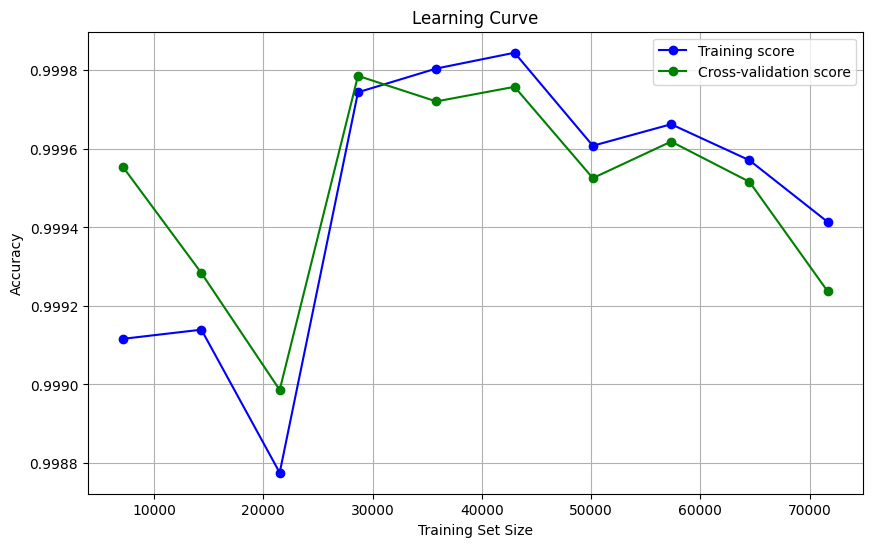

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier

# Assuming these arrays exist:
# densities_array and Austin_class["Void Classification"]

scaler = StandardScaler()

# Combine features (only densities in this case)
features = np.column_stack((densities_array,))
results = np.array(Austin_class["Void Classification"])

# Shuffle
indices = np.random.permutation(len(features))
features = features[indices]
results = results[indices]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, results, test_size=0.2, random_state=42)

# Scale features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check balance
print("Training set size:", len(X_train))
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

# Set up model and grid search
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'max_depth': [6, 8, 10, None],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.3, 0.5]
}

kf = KFold(n_splits=3, shuffle=True, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # adjust to 'macro' or 'weighted' if multiclass
recall = recall_score(y_test, y_pred, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Optimal Parameters:", grid_search.best_params_)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, features, results, cv=kf, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()



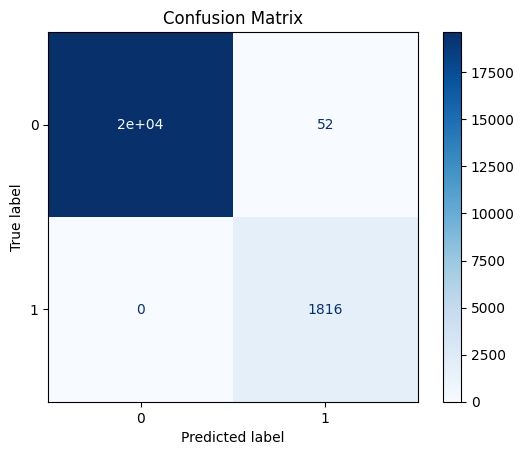

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust labels to match the number of classes
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# DBSCAN

In [10]:
from collections import OrderedDict
from collections import Counter

def helper(y):
    ordered_dict = OrderedDict()
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        indices = np.where(pos)[0]
        ordered_dict[yu] = indices
    return ordered_dict

def entropy(y):
    H = 0
    ordered = helper(y)
    for key in ordered:
        H -= len(ordered[key])/len(y)*np.log(len(ordered[key])/len(y))
      
    return H

def mutual_information(labels_true, labels_pred):
    n_samples = len(labels_true)
    contingency = Counter(zip(labels_true, labels_pred))
    mi = 0
    for (i, j), n_ij in contingency.items():
        # Joint probability
        p_ij = n_ij / n_samples
        
        # Marginal probabilities
        p_i = np.sum([n for (x, _), n in contingency.items() if x == i]) / n_samples
        p_j = np.sum([n for (_, y), n in contingency.items() if y == j]) / n_samples
        
        # Add to mutual information
        if p_ij > 0:
            mi += p_ij * np.log(p_ij / (p_i * p_j))
    
    return mi

def NMI(X,Y):
    return 2*mutual_information(X,Y)/(entropy(X)+entropy(Y))

from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plot_clustering(X,y):
    plt.figure(figsize=(8,6))
    for i, yu in enumerate(np.unique(y)):
    
        pos = (y == yu)
        
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])
        
    plt.show()

Best parameters: {'eps': 10, 'min_samples': 5}
Best Accuracy: 0.917927249046423


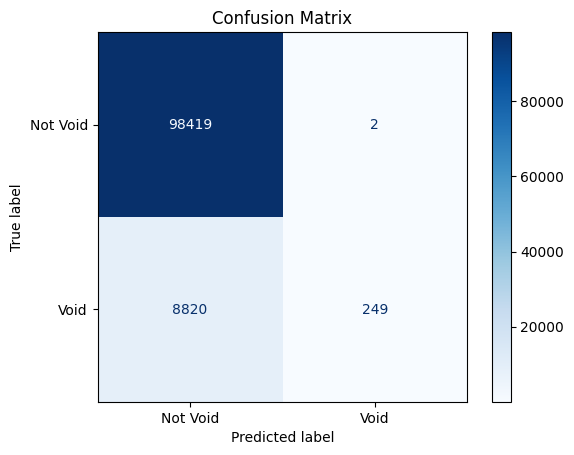

Precision: 0.9920
Recall: 0.0275


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

best_accuracy = -1
results_list = []

positions = np.column_stack((Austin_class['X'], Austin_class['Y'], Austin_class['Z']))
true_labels = np.array(Austin_class["Void Classification"])  # 0 = not void, 1 = void

for eps in [0.01, 0.05, 0.1, 0.1, 1, 10, 20, 50]:
    for min_samples in [1, 5, 20, 40, 100, 200]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(positions)

        # Convert cluster labels: cluster -> 0, noise -> 1
        predicted_void = np.where(cluster_labels == -1, 1, 0)

        acc = accuracy_score(true_labels, predicted_void)
        results_list.append({"eps": eps, "min_samples": min_samples, "accuracy": acc})

        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {"eps": eps, "min_samples": min_samples}

print("Best parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Fit the best model again
dbscan = DBSCAN(eps=best_params["eps"], min_samples=best_params["min_samples"])
cluster_labels = dbscan.fit_predict(positions)

# Predict void: noise = 1, others = 0
predicted_void = np.where(cluster_labels == -1, 1, 0)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_void, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Void", "Void"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Precision and Recall
precision = precision_score(true_labels, predicted_void)
recall = recall_score(true_labels, predicted_void)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
